In [ ]:
-- 1. Who were the top 5 sellers?
SELECT s.sellerid, (u.firstname + ' ' + u.lastname) AS seller_name, SUM(s.pricepaid) AS total_sales
FROM sales s
LEFT JOIN users u
ON s.sellerid = u.userid
GROUP BY s.sellerid, seller_name
ORDER BY total_sales DESC
LIMIT 5;

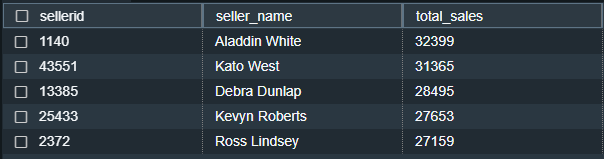

In [ ]:
-- 2. What were the highest selling individual events?
SELECT e.eventid, e.eventname, SUM(s.pricepaid) AS total_sales
FROM sales s
LEFT JOIN events e ON e.eventid = s.eventid
GROUP BY e.eventid, e.eventname
ORDER BY total_sales DESC
LIMIT 5;

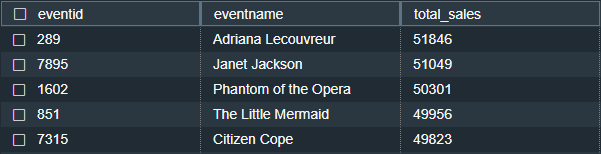

In [ ]:
-- 3. What were the sales by year and quarter?
WITH quarterly_sales AS (
    SELECT EXTRACT(YEAR FROM saletime) AS year,
           EXTRACT(QUARTER FROM saletime) AS quarter,
           ROUND(SUM(pricepaid) / 1000000, 2) as sales_mil
    FROM sales
    GROUP BY year, quarter 
),
change_in_sales AS (
    SELECT year, quarter, sales_mil,
    sales_mil - LAG(sales_mil) OVER(ORDER BY year, quarter) AS sales_change_mil
    FROM quarterly_sales
    ORDER BY year, quarter
)
SELECT *
FROM change_in_sales;

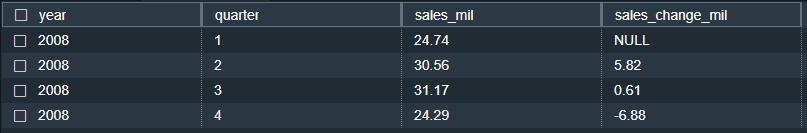

In [ ]:
-- 4. Who were the top 5 buyers by quantity?
SELECT s.buyerid, u.firstname, u.lastname, SUM(s.qtysold) AS sold
FROM sales s
LEFT JOIN users u ON s.buyerid = u.userid 
GROUP BY s.buyerid, u.firstname, u.lastname
ORDER BY sold DESC
LIMIT 5;

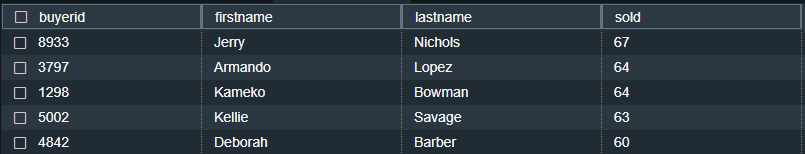

In [ ]:
-- 5. What % of listed ticktes were actually sold?
WITH total_tx AS (
    SELECT SUM(numtickets) AS total_tickets
    FROM listings
),

tx_sold AS (
    SELECT SUM(qtysold) AS tickets_sold
    FROM sales
)

SELECT tickets_sold, total_tickets, ROUND(CAST(tickets_sold AS NUMERIC) / CAST(total_tickets AS NUMERIC), 3) AS pct_sold
FROM total_tx, tx_sold;

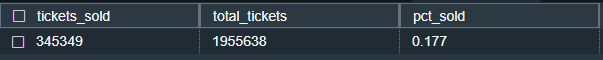

In [ ]:
-- 6. How many users are sellers, buyers, or both?
WITH tab AS (SELECT userid,
    CASE WHEN
        userid IN (SELECT sellerid
                    FROM listings) THEN 'yes'
    ELSE 'no'
    END AS seller,
    CASE WHEN
        userid IN (SELECT buyerid
                    FROM sales) THEN 'yes'
    ELSE 'no'
    END AS buyer
FROM users
),

total AS(
SELECT COUNT(userid) AS num_users
FROM tab
),

only_buyers AS(
SELECT COUNT(buyer) AS only_buyer
FROM tab
WHERE buyer = 'yes' AND seller = 'no'
),

only_sellers AS(
SELECT COUNT(seller) AS only_seller
FROM tab
WHERE buyer = 'no' AND seller = 'yes'
),

both_users AS(
SELECT COUNT(userid) AS seller_and_buyer
FROM tab
WHERE buyer = 'yes' AND seller = 'yes'
),    

none_users AS(
SELECT COUNT(userid) AS neither
FROM tab
WHERE buyer = 'no' AND seller = 'no'
)

SELECT num_users, only_buyer, only_seller, seller_and_buyer, neither
FROM total, only_buyers, only_sellers, both_users, none_users;

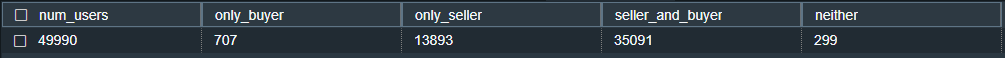

In [ ]:
-- 7. What events resulted in the most expensive single ticket?
SELECT e.eventid, e.eventname, MAX(s.pricepaid/s.qtysold) AS individual_ticket_price
FROM sales s
LEFT JOIN events e
ON s.eventid = e.eventid
GROUP BY e.eventid, e.eventname
ORDER BY individual_ticket_price DESC
LIMIT 5;

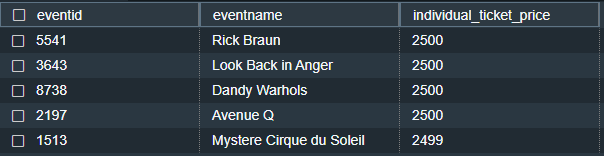

In [ ]:
-- 8. What was our commission percentage on each sale?
SELECT pricepaid, commission, (commission/pricepaid*100) AS pct_commision
FROM sales
LIMIT 5;

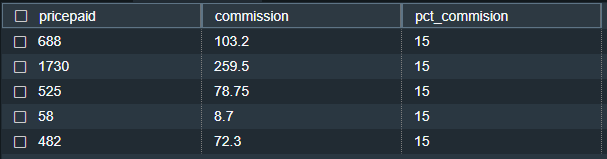

In [ ]:
-- 9. What were our cumulative sales commissions (in millions of dollars) by month?
SELECT EXTRACT(MONTH FROM saletime) AS month, ROUND(SUM(commission/1000000), 3) AS month_commission_million,
    SUM (month_commission_million) OVER(
        ORDER BY month
        ROWS UNBOUNDED PRECEDING
    ) cumulative_commission_million
FROM sales
GROUP BY month
ORDER BY month;

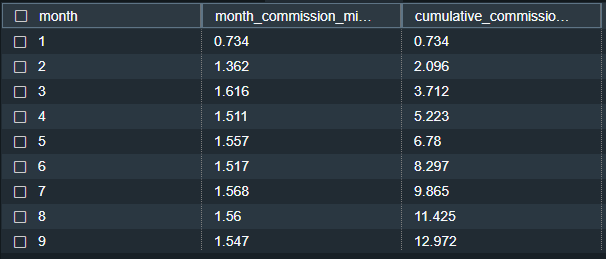
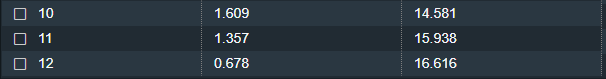

In [ ]:
-- 10. What was our "listings-to-seats" ratio for each event?
WITH lists AS(
SELECT eventid, SUM(numtickets) AS tickets_listed
FROM listings
GROUP BY eventid
),

venue_seat AS(SELECT e.eventid, e.eventname, e.venueid, v.venuename, SUM(v.venueseats) AS seats
FROM events e
LEFT JOIN venues v USING (venueid)
GROUP BY e.venueid, v.venuename, e.eventid, e.eventname
HAVING seats > 0
),

ratio AS(SELECT eventid, eventname, venueid, venuename, tickets_listed, seats, ROUND(CAST(tickets_listed AS NUMERIC )/ CAST(seats AS NUMERIC), 4) AS listings_to_seats
FROM lists l
INNER JOIN venue_seat v USING(eventid)
)

SELECT *
FROM ratio
ORDER BY listings_to_seats DESC;

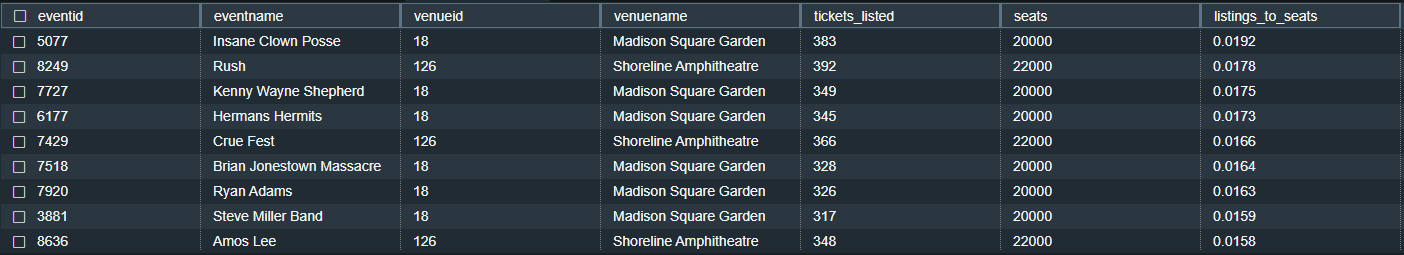